# Trabajo Final - Aprendizaje Profundo

## Ejercicio 1 

### Alumno: Domenje Carlos



### ✒️ Enunciado

1) Descargar el dataset desde el siguiente link. Entrenar el modelo propuesto a continuación
de este enunciado. El modelo está haciendo underfitting, overfitting o un fit correcto. ¿Por
qué? Explicar el procedimiento realizado.
𝑦ℎ𝑎𝑡= 𝑋3𝑊1+𝑋2𝑊2+𝑋𝑊1+𝑏

### 💾 Imports de librerias necesarias 


In [2]:

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc
np.random.seed(20)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import sklearn.metrics as metrics

### 📟 Lectura del Dataset



In [3]:
dataset = pd.read_csv('./data/dataset_1.csv')

In [4]:
# Observación estadística de los datos
dataset.describe()

,# X,Y
count,10000.000000,10000.000000
mean,1.000000,2.029839
std,0.577437,2.303106
min,0.000000,-0.897512
25%,0.500000,0.383598
50%,1.000000,1.105209
75%,1.500000,3.831945
max,2.000000,8.912945


In [5]:
# Chequeo si hay datos nulos
dataset.isnull().sum()

# X    0
Y      0
dtype: int64

In [6]:
# Cambio el nombre de la columna # X solo por X
dataset.rename(columns = {'# X':'X'}, inplace = True)

dataset.describe()

,X,Y
count,10000.000000,10000.000000
mean,1.000000,2.029839
std,0.577437,2.303106
min,0.000000,-0.897512
25%,0.500000,0.383598
50%,1.000000,1.105209
75%,1.500000,3.831945
max,2.000000,8.912945


#### Separación de datos para entrenamiento y test

In [7]:
X = dataset[["X"]]
y = dataset[["Y"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=50)

In [8]:
# Chequeamos la presencia relativa de cada clase y el tamaño de los nuevos datasets
print('Datos para Entrenamiento:',X_train.shape)
print('Datos para Testeo:',X_test.shape)
print('Datos para Entrenamiento:',y_train.shape)
print('Datos para Testeo:',y_test.shape)

Datos para Entrenamiento: (7500, 1)
Datos para Testeo: (2500, 1)
Datos para Entrenamiento: (7500, 1)
Datos para Testeo: (2500, 1)


### Resolución del problema aplicando MiniBatch

- Para el forward, tomamos la resolución de la fórmula del enunciado.
- Para el backward debemos tomar las derivadas con respecto a los pesos W1, W2 y el bias. 
- Cuando terminamos de calcular todas las derivadas actualizamos todos los pesos y bias.
- Repetimos el proceso por la cantidad de batches tomada.
- Vovemos a repetir todo el proceso por cada época definida. 

![miniBatch](./img/miniBatch_class.png)

### Definición de clase para aplicar MiniBatch

In [9]:
class MiniBatch:

    def __init__(self):
        # Definimos los pesos, bias, error total, tamaño de batch a utilizar.
        self.w_1 = self.init_uniform_params()
        self.w_2 = self.init_uniform_params()
        self.bias = self.init_uniform_params()
        self.total_mse = []
        self.test_total_mse = []
        self.b_size = 0
        self.lr = 0
    
    # Funcion para inicializar valores teniendo una distribucion uniforme.
    # Para nuestro caso, inicializamos los pesos y bias.
    def init_uniform_params(self):
        return np.random.uniform(low=0.0, high=1.0)

    # Funcion para realizar la forward propagation.
    def forward_propagation(self, X):
        x_1, x_2, x_3 = X, X**2, X**3
        return self.w_1 * x_3 + self.w_2 * x_2 + self.w_1 * x_1 + self.bias

    # Funcion para la retropropagacion, donde tenemos todas las derivadas.
    def back_propagation(self, X, error):
        x_1, x_2, x_3 = X, X ** 2, X ** 3

        
        d_L_error = - 2 * error
        d_w_1_l = (d_L_error * (x_3 + x_1)).sum(axis=0)
        d_w_2_l = (d_L_error * x_2).sum(axis=0)
        d_bias_l = d_L_error.sum(axis=0)

        # Una vez calculadas las derivadas debemos actualizar los pesos.
        self.w_1 -= self.lr * d_w_1_l / self.b_size
        self.w_2 -= self.lr * d_w_2_l / self.b_size
        self.bias -= self.lr * d_bias_l / self.b_size

    def create_batches(self, X, y, batch_size):
        batches = []
      
        data = np.hstack((X, y))
        np.random.shuffle(data)
        n_batches = data.shape[0] 
        i = 0

        for i in range(n_batches + 1):
            mini_batch = data[i * batch_size:(i + 1) * batch_size, :]
            X_mini = mini_batch[:, :-1]
            Y_mini = mini_batch[:, -1].reshape((-1, 1))
            batches.append((X_mini, Y_mini))

        if data.shape[0] % batch_size != 0:
            mini_batch = data[i * batch_size:data.shape[0]]
            X_mini = mini_batch[:, :-1]
            Y_mini = mini_batch[:, -1].reshape((-1, 1))
            batches.append((X_mini, Y_mini))

        return batches

    # Funcion para realizar el entrenamiento del algoritmo.
    def train(self, X, y, X_test, y_test, n_epochs, lr, b_size):
        self.b_size = b_size
        self.lr = lr

        for epoch in range(1, n_epochs+1):
            i_err, val_iter_error = 0, 0
            
            batches = self.create_batches(X, y, self.b_size)
            value_batches = self.create_batches(X_test, y_test, self.b_size)

            for batch in batches:
                X_b, y_b = batch

                # Calculamos el forward
                predict = self.forward_propagation(X_b)

                # Calculamos el error
                error = y_b - predict
                i_err += np.sum(error ** 2) / self.b_size

                # Realizamos la backpropagation
                self.back_propagation(X_b, error)
            # Almacenamos el error MSE
            self.total_mse.append(i_err / n_epochs)

            for value_batch in value_batches:
                X_value_batch, y_value_batch = value_batch

                # forward
                predict = self.forward_propagation(X_value_batch)

                # error
                error = y_value_batch - predict
                val_iter_error += np.sum(error ** 2) / self.b_size

            self.test_total_mse.append(val_iter_error / n_epochs)

            

    def make_prediction(self, data):
        predict = self.forward_propagation(data)
        return predict

#### Utilización de mini batch y entrenamiento del modelo

In [10]:
miniBatch = MiniBatch()

miniBatch.train(X_train, y_train, X_test, y_test, n_epochs=800, b_size=32, lr=0.005)




#### Visualización de resultados del error

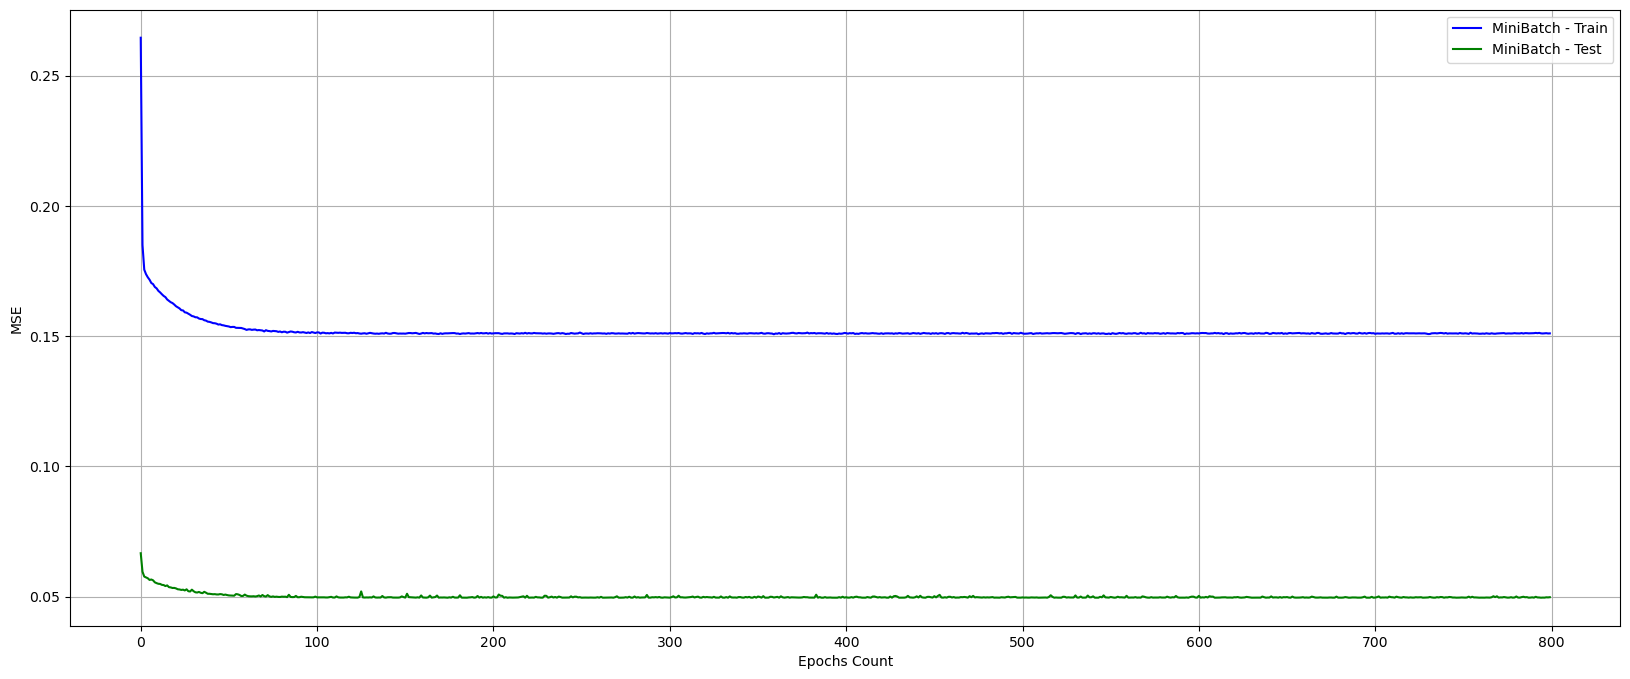

In [11]:



plt.figure(figsize=(20,8))
plt.grid(True, which='both')
plt.axis()
plt.plot(miniBatch.total_mse, label='MiniBatch - Train',color='b')
plt.plot(miniBatch.test_total_mse, label='MiniBatch - Test',color='g')
plt.xlabel("Epochs Count")
plt.ylabel("MSE")
plt.legend()
plt.show()

### Testeo de la aplicación de miniBatch

In [12]:
# Calculo el forward para el dataset de test

y_h = miniBatch.make_prediction(X_test)

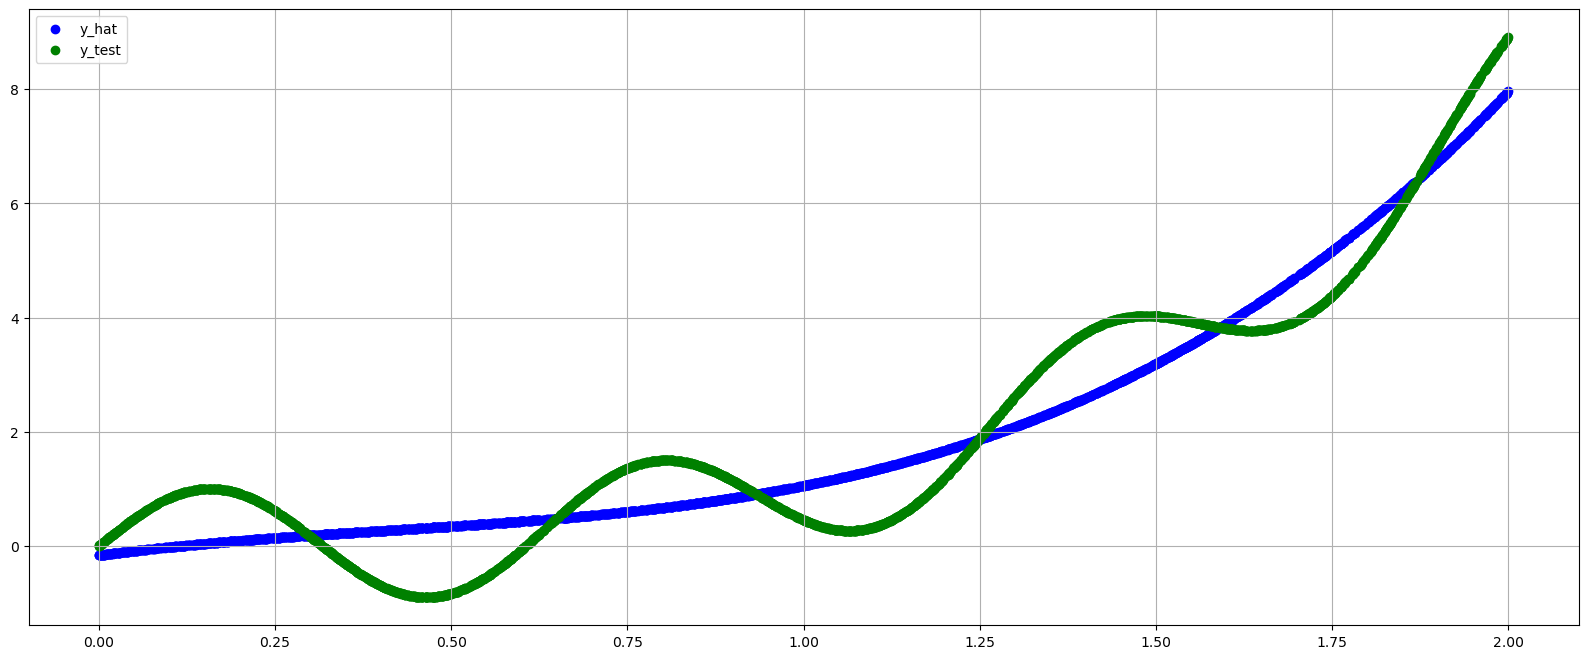

In [13]:
# Comparo los resultados entre el forward obtenido (y_h) y el y_test calculado anteriormente
plt.figure(figsize=(20,8))
plt.grid(True, which='both')
plt.axis()
plt.scatter(X_test, y_h, label='y_hat',color='b')
plt.scatter(X_test, y_test, label='y_test',color='g')
plt.legend()
plt.show()

#### Métricas

In [14]:
print("R2 score para testing: {}".format(r2_score(y_test, y_h)))

R2 score para testing: 0.9040090739608926


In [15]:
y_train_hat = miniBatch.make_prediction(X_train)
print("R2 score para training:: {}".format(r2_score(y_train, y_train_hat)))

R2 score para training:: 0.9028222603367413


### Conclusion

Para la realización de este ejercicio se decidio aplicar Mini Batch.

Para obtener el error, se guardó cada valor del MSE tanto para el entrenamiento como en la validación. Podemos ver que la pérdida en el set de validación es mas baja que la pérdida en el entranamiento.

Por último se tomó la métrica R2 para ver los resultados logrados y se obtuvo un 0.90 lo cuál dependiendo el tipo de aplicación podemos inferir que los resultados son satisfactorios.

A través de las gráficas se puede inferir que tenemos un underfitting ya que el modelo esta muy ligado al bias y eso hace que sea poco flexible para poder aprender bien la función.
